In [ ]:
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan


In [ ]:
# Load LSI vectors and speech IDs
with open("pkl_files/lsi_vectors.pkl", "rb") as f:
    lsi_vectors = pickle.load(f)

with open("pkl_files/speech_ids.pkl", "rb") as f:
    speech_ids = pickle.load(f)

# Normalize LSI vectors
lsi_vectors_normalized = normalize(lsi_vectors)



# k-means

In [ ]:
# Define the range for number of clusters
cluster_range = range(10, 250, 10)  # From 10 to 100 clusters

# Initialize lists to store evaluation metrics
wcss = []
silhouette_scores = []
# Determine optimal number of clusters using Elbow Method and Silhouette Analysis
for k in cluster_range:
    mbk = KMeans(n_clusters=k, random_state=42, n_init='auto')
    mbk.fit(lsi_vectors_normalized)
    wcss.append(mbk.inertia_)
    
    # Compute silhouette score on a sample
    sample_size = 10000
    sil_score = silhouette_score(lsi_vectors_normalized, mbk.labels_, metric='cosine', sample_size=sample_size, random_state=42)
    silhouette_scores.append(sil_score)
    
    print(f"Processed k={k}, WCSS={mbk.inertia_:.2f}, Silhouette Score={sil_score:.4f}")

Processed k=10, WCSS=72727.35, Silhouette Score=0.0887
Processed k=20, WCSS=66797.14, Silhouette Score=0.0819
Processed k=30, WCSS=62738.23, Silhouette Score=0.1042
Processed k=40, WCSS=59310.26, Silhouette Score=0.1225
Processed k=50, WCSS=56435.64, Silhouette Score=0.1285
Processed k=60, WCSS=54373.83, Silhouette Score=0.1335
Processed k=70, WCSS=52891.68, Silhouette Score=0.1335
Processed k=80, WCSS=51790.30, Silhouette Score=0.1284
Processed k=90, WCSS=50924.15, Silhouette Score=0.1223
Processed k=100, WCSS=49919.28, Silhouette Score=0.1283
Processed k=110, WCSS=49317.16, Silhouette Score=0.1204
Processed k=120, WCSS=48646.99, Silhouette Score=0.1151
Processed k=130, WCSS=48190.31, Silhouette Score=0.1127
Processed k=140, WCSS=47325.49, Silhouette Score=0.1136
Processed k=150, WCSS=46967.20, Silhouette Score=0.1164
Processed k=160, WCSS=46498.22, Silhouette Score=0.1143
Processed k=170, WCSS=46053.17, Silhouette Score=0.1145
Processed k=180, WCSS=45698.89, Silhouette Score=0.1124
P

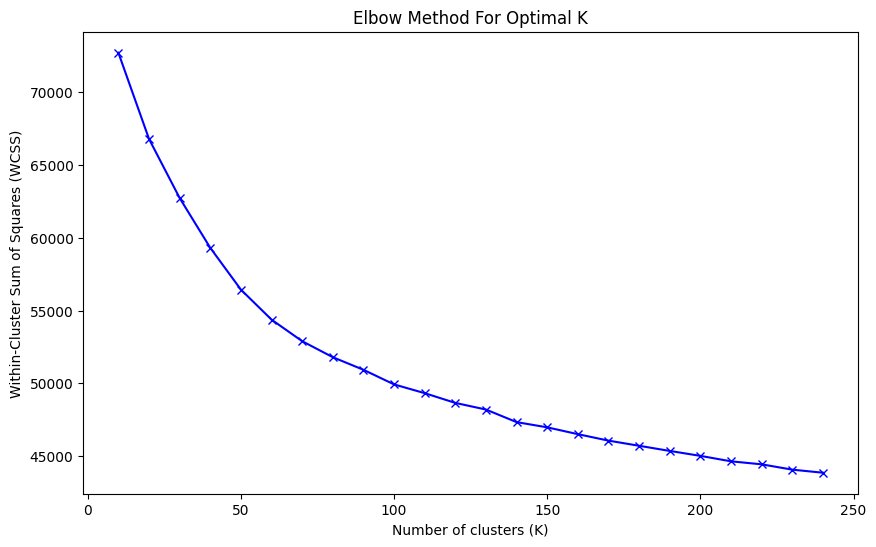

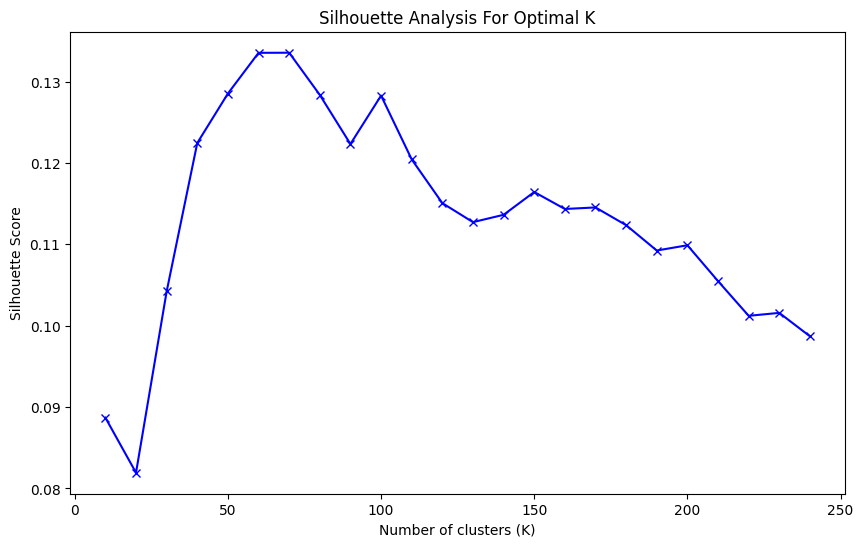

In [11]:
# Plot Elbow Method
plt.figure(figsize=(10,6))
plt.plot(cluster_range, wcss, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal K')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10,6))
plt.plot(cluster_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal K')
plt.show()

# DB-SCAN

In [ ]:
# Step 2: Initialize and fit the HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=50,            # Minimum size of clusters (adjust based on data structure)
    min_samples=10,                 # Minimum samples in a neighborhood to be considered a cluster
    metric='cosine',                # Use cosine distance for text data
    cluster_selection_method='eom', # 'eom' (excess of mass) identifies the most stable clusters
    n_jobs=-1                       # Use all CPU cores for faster computation
)

# Fit the model to the normalized LSI vectors
labels = hdbscan_model.fit_predict(lsi_vectors_normalized)

# Step 3: Analyze results
# Count the number of clusters (ignoring noise points labeled as -1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"HDBSCAN found {num_clusters} clusters.")

# Check for noise points
noise_ratio = (labels == -1).sum() / len(labels)
print(f"Noise points: {noise_ratio:.2%} of the data.")

# Step 4: Evaluate clustering quality (optional, but only if clusters are well-defined)
if num_clusters > 1:
    sil_score = silhouette_score(lsi_vectors_normalized, labels, metric='cosine')
    print(f"Silhouette Score for HDBSCAN: {sil_score:.4f}")
else:
    print("Silhouette score not calculated: Only one cluster found.")

# Step 5: Access cluster labels
# Each index corresponds to a speech, and labels array shows cluster assignments
print(labels[:10])  # Print the first 10 cluster labels